In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

train_data = pd.read_csv('dataset/price_data_tr.csv')
heldout_data = pd.read_csv('dataset/price_data_val.csv')
test_data = pd.read_csv('dataset/price_data_ts.csv')

In [13]:
#print(train_data.shape) #(12968, 21)
#print(heldout_data.shape) #(4323, 21)
#print(test_data.shape) #(4322, 21)

# data.columns
# 'id', 'date', 
# 'price', 
# 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
# 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'

In [14]:
nor_train = train_data.iloc[:, 3:-1].apply(lambda x: (x-x.mean()) / (x.std()))
nor_heldout = heldout_data.iloc[:, 3:-1].apply(lambda x: (x-x.mean()) / (x.std()))
nor_test = test_data.iloc[:, 3:-1].apply(lambda x: (x-x.mean()) / (x.std()))

nor_log_train_price = np.log(train_data.iloc[:, 2:3]).apply(lambda x: (x-x.mean()) / (x.std()))
nor_log_heldout_price = np.log(heldout_data.iloc[:, 2:3]).apply(lambda x: (x-x.mean()) / (x.std()))

In [15]:
np.log(train_data.iloc[:, 2:3]).mean()

price    13.048107
dtype: float64

In [16]:
train_log_label_mean, train_log_label_std = np.log(train_data.iloc[:, 2]).mean(), np.log(train_data.iloc[:, 2]).std()
heldout_log_label_mean, heldout_log_label_std = np.log(heldout_data.iloc[:, 2]).mean(), np.log(heldout_data.iloc[:, 2]).std()
print(train_log_label_mean, train_log_label_std)
print(heldout_log_label_mean, heldout_log_label_std)

uni_log_label_mean = np.log(pd.concat((train_data.iloc[:, 2], heldout_data.iloc[:, 2]))).mean()
uni_log_label_std = np.log(pd.concat((train_data.iloc[:, 2], heldout_data.iloc[:, 2]))).std()
print(uni_log_label_mean, uni_log_label_std)

13.04810655020148 0.5220080959315785
13.048257499579405 0.5355929705203868
13.048144289728448 0.5254218546587482


In [17]:
train_feats = torch.tensor(nor_train.iloc[:, :].values, dtype=torch.float32)
train_labels = torch.tensor(nor_log_train_price.values.reshape(-1, 1), dtype=torch.float32)

heldout_feats = torch.tensor(nor_heldout.iloc[:, :].values, dtype=torch.float32)
heldout_labels = torch.tensor(nor_log_heldout_price.values.reshape(-1, 1), dtype=torch.float32)

test_feat = torch.tensor(nor_test.iloc[:, :].values, dtype=torch.float32)

In [18]:
n_train, in_features = train_data.shape[0], train_feats.shape[1]


class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(in_features, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 8)
        self.fc6 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU() # trial 5
#         self.relu = nn.PReLU() # trial 3, 6
#         self.relu = nn.SELU() # trial 4, 7
#         self.relu = nn.Tanh() # trial 8
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc5(x)
        x = self.relu(x)
#         x = self.dropout(x) # trial 2 유 / 5,6,7 무
        
        x = self.fc6(x)
        return x
    
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [19]:
learning_rate = 0.001
weight_decay = 0.1
batch_size = 512
epochs = 100

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Regressor().to(device)

criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate, lr_decay=0, weight_decay=weight_decay, initial_accumulator_value=0, eps=1e-10)

In [20]:
train_features, train_labels  = train_feats.to(device), train_labels.to(device)
test_features, test_labels = heldout_feats.to(device), heldout_labels.to(device)

dataset = TensorDataset(train_features, train_labels)
dataloader = DataLoader(dataset, batch_size=batch_size)

train_ls, test_ls = [], []

for epoch in range(800):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    train_rmse = criterion(net(train_features), train_labels).item()
    test_rmse = criterion(net(test_features), test_labels).item()
    
    train_ls.append(train_rmse)
    test_ls.append(test_rmse)

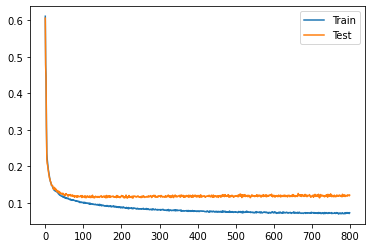

0.0732, 0.1214


In [21]:
plt.plot(train_ls, label="Train")
plt.plot(test_ls, label="Test")
plt.legend()
plt.show()

print(f'{train_ls[-1]:0.4f}, {test_ls[-1]:0.4f}')

In [11]:
trains = []
helds = []
unis = []

for i in range(1000):
    predicts = net(test_features).to('cpu').detach().numpy()

    train_predicts = np.exp(predicts * train_log_label_std + train_log_label_mean)
    held_predicts = np.exp(predicts * heldout_log_label_std + heldout_log_label_mean)
    uni_predicts = np.exp(predicts * uni_log_label_std + uni_log_label_mean)

    rmse_train = rmse(train_predicts, heldout_data.iloc[:, [2]].values)
    rmse_held = rmse(held_predicts, heldout_data.iloc[:, [2]].values)
    rmse_uni = rmse(uni_predicts, heldout_data.iloc[:, [2]].values)
    
    trains.append(rmse_train)
    helds.append(rmse_held)
    unis.append(rmse_uni)

print(np.array(trains).mean())
print(np.array(helds).mean())
print(np.array(unis).mean())

137104.66439229043
135624.49861266607
136582.84829388844


In [101]:
finals = []

for i in range(1000):
    test_predicts = net(test_feat.to('cuda')).cpu().detach().numpy()
    final_predict = np.exp(test_predicts * uni_log_label_std + uni_log_label_mean)
    finals.append(final_predict)
np.array(finals).mean(axis = 0)

array([[643628.2 ],
       [476315.25],
       [200871.36],
       ...,
       [885213.8 ],
       [576023.06],
       [380764.88]], dtype=float32)

In [102]:
test_data = pd.read_csv('dataset/price_data_ts.csv')
test_data['price'] = np.array(finals).mean(axis = 0)

test_data['id'] = test_data['id'].apply(lambda x : str(x) if len(str(x)) == 10 else '0' + str(x) if len(str(x)) == 9 else '00' + str(x))
test_data['id'] = test_data['id'].astype(str) + test_data['date'].astype(str)
submission = pd.concat([test_data['id'], test_data['price']], axis=1)
submission

,id,price
0,700010085020140926T000000,643628.187500
1,403740028020140923T000000,476315.250000
2,142340016020140618T000000,200871.359375
3,776740006020141119T000000,452570.437500
4,946590050020140617T000000,560632.250000
...,...,...
4317,733822037020141006T000000,308283.187500
4318,681910015020140721T000000,601546.187500
4319,082405914020140527T000000,885213.812500
4320,051450009020140513T000000,576023.062500


In [100]:
submission.to_csv('submission.csv', index=False)